# ODMR Varience meansurement. 

The aim of this scipt is to be able to take an ODMR dataset and calculate the varience of the photons collected for each of the applied microwave frequnencies and to determine the signal to noise for the measurement. 

For the first use of this program, the dataset under investigation will have 1000 line scans in it. 

The idea is that we can split this dataset in a number of different ways. 100 lots of 10, 50 lots of 20, 25 lots of 50 and so on. 

We can then look at the consistency of the measurements across the whole dataset. 

In [3]:
import numpy as np 
import scipy.optimize as opt
import matplotlib.pyplot as plot 
import os
import pandas as pd

In [4]:
def load_data(file_path): 
    # load the ODMR data file in to an np array 
    data_array = np.loadtxt(file_path)
    return(data_array)

In [5]:
def load_params(file_path):
    # load in the params data. 
    params_data = pd.read_table(file_path, names = ['Parameter name', 'Parameter value']) 
    return(params_data)

In [6]:
def create_freq_scan(start, stop, step_size):
    # takes the scan parameters from the params data file. 
    step_size_GHz = step_size/1000
    number_of_steps = int((stop-start)/step_size_GHz)+1
    freq = np.linspace(start, stop, number_of_steps)
    
    return(freq)

In [7]:
def set_plot_params():
    # formats the plot parameters 
    plot.rcParams.update({'font.size' : 16})
    plot.rcParams.update({'figure.figsize' :[12, 8]})

In [8]:
def plot_heat_map(freq, odmr_data, dwell_time):
    # plot the full ODMR data as a heatmap. 
    number_of_scans = len(odmr_data)
    Y = np.linspace(1, number_of_scans, number_of_scans) 
    
    fig1, ax1 = plot.subplots()
    
    hm = ax1.pcolormesh(freq, Y, odmr_data, cmap = 'viridis', shading='auto')
    fig1.colorbar(hm, label = '\ncounts per ' + str(dwell_time) + r' $\mu$s')
    ax1.set_xlim(np.min(freq),np.max(freq))
    ax1.set_xticks(np.arange(np.min(freq), np.max(freq), 0.05))
    ax1.set_xlabel('Microwave Frequency (GHz)')
    ax1.set_ylabel('Number of scans')
    
    return(fig1, ax1)

In [9]:
def scatter_plot(freq,mean_data):
    # Creates a scatter plot for experimental data and plot parameters. 
    fig2, ax2 = plot.subplots()
    ax2.scatter(freq, mean_data, marker = 'x',color = 'r', label = "ODMR Data")
    ax2.set_xlim(np.min(freq),np.max(freq))
    return(fig2, ax2)

In [10]:
def mean_and_std(odmr_subset): 
    '''Here we will find the mean for a given sub-set of the data and the varience.'''
    
    mean_data = np.sum(odmr_subset, axis = 0)
    standard_dev = np.std(odmr_subset, axis = 0, ddof = 1)
    
    return(mean_data, standard_dev)

In [11]:
def get_init_params(odmr_data, freq):
    # find the minima of the ODMR spectra and ODMR dip contrast and 
    # flourenscent baseline.
    
    half_data_length = int((len(freq)-1)/2) - 5 # This brings the mid-value to 2.87GHz 
    
    #find the indices for the lowest frequency value
    low_freq_min_index = np.where(odmr_data[0:half_data_length] == np.min(odmr_data[0:half_data_length]))
    high_freq_min_index = np.where(odmr_data[half_data_length:len(odmr_data)-1] == 
                                   np.min(odmr_data[half_data_length:len(odmr_data)-1]))
   
    # frequencies corresponding to ODMR minima
    freq_mins = [np.float(freq[low_freq_min_index[0]]),
                 np.float(freq[high_freq_min_index[0]+half_data_length])]
    
    # manually set frequencies. 
    
    #freq_mins = [2.78, 2.96]
    
    flourescent_baseline = np.mean(odmr_data)
    
    # approximate dip_depth
    dip_depth = [odmr_data[low_freq_min_index[0][0]]  - flourescent_baseline, 
                 odmr_data[high_freq_min_index[0][0]+half_data_length]  - flourescent_baseline]
    
    #contrast = [np.float((1-odmr_data[low_freq_min_index[0]]/flourescent_baseline)), 
    #            np.float((1-odmr_data[high_freq_min_index[0]+half_data_length]/flourescent_baseline))]

    return(freq_mins, dip_depth, flourescent_baseline)

In [12]:
def optimised_lorentz_fit(freq, mean_data, init_params, lower_bounds, upper_bounds):
    # A method to find the fitting prameters for the ODMR dataset. 
    y_error = np.sqrt(mean_data) # poissonian noise
    coeffs, confidence = opt.curve_fit(double_lorentz, freq, mean_data, init_params, 
                                       sigma = y_error, bounds = (lower_bounds, upper_bounds))
    opt_error = np.sqrt(np.diag(confidence))
    
    return(coeffs, opt_error)

In [13]:
def double_lorentz(x, A1, X01, sig1, A2, X02, sig2, offset): #P0[0], P0[1], P0[2], P0[3], P0[4], P0[5], P0[6]):
    # A1 = Amplitude 1, X01 = Resonance 1, sig1 = FWHM 1
    # A2 = Amplitude 2, X02 = Resonance 2, sig2 = FWHM 2, offset = offset
    
    first_peak = (A1/np.pi)*((sig1**2)/(sig1**2 +(2*x-2*X01)**2))
    second_peak = (A2/np.pi)*((sig2**2)/(sig2**2 +(2*x-2*X02)**2))
    
    return (first_peak + second_peak + offset)

In [14]:
def plot_fitting(ax2, freq, dwell_time):
    # plot the y fit. 
    
    high_res_freq = np.linspace(freq[0], freq[len(freq)-1], 10*len(freq)+1)
    
    # create the double lorentz fit array
    y_fit_high_res = double_lorentz(high_res_freq, fitting_params[0], fitting_params[1], fitting_params[2], 
                  fitting_params[3], fitting_params[4], fitting_params[5], fitting_params[6])
    
    y_fit = double_lorentz(freq, fitting_params[0], fitting_params[1], fitting_params[2], 
                  fitting_params[3], fitting_params[4], fitting_params[5], fitting_params[6])
    
    ax2.plot(high_res_freq, y_fit_high_res, color='k', label='Double Lorentz \nfitting')
    ax2.legend()
    ax2.set_xlabel('Microwave Frequency (GHz)', fontsize = 18)
    ax2.set_ylabel('Counts per ' + str(dwell_time) + r'$\mu$s', fontsize = 18)
    
    return(ax2, y_fit)

In [15]:
def get_r_squared(x, y_data, y_fitting):
    # This is a function used to generate the goodness of fit metric r^2.
    # This value will be used to judge the effectiveness of the curve fitting 
    # used to find the resonant frequencies of the NV centre.
    
    y_data_mean = np.mean(y_data)
    SStot = np.sum((y_data - y_data_mean)**2) # Find the variation in experimental y values.
    SSres = np.sum((y_data - y_fitting)**2) # Find the variation betweem the experimental and fitted y values. 
    
    r_squared = 1 - (SSres/SStot) # Calculate R^2
    
    return(r_squared)

1
r squared = 0.9884013833140772
FWHM 1 = 11.863 MHz
FWHM 2 = 9.027 MHz


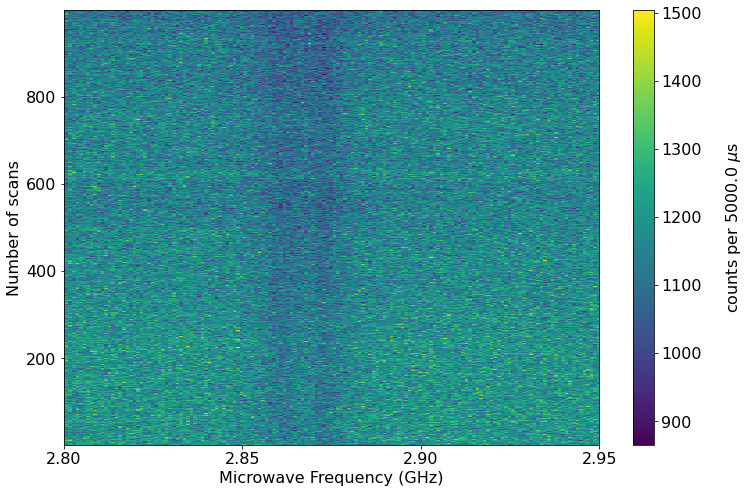

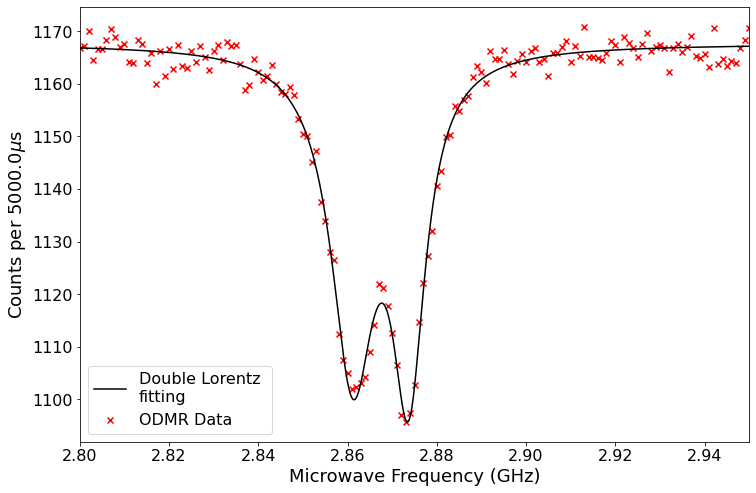

In [96]:
# Load in the data file into an np array, and freqeuncy scan parameters 
# into a pandas array.
folder_path = 'I:\\Science\\Physics-Nanobiophotonics\\Group\\User Data\\ODMR\\ODMR and imaging\\'
date = '20210429'
file_name = date + '_NVScan_27_edited'
#nd_number = int(file_name[-2:]) - 1
nd = 1#np.remainder(nd_number, 5) + 1

print(nd)

odmr_data = load_data(folder_path + date + '\\' + file_name + '.dat')
params_file = load_params(folder_path + date + '\\' + file_name + 'Params.dat')
params_values = params_file['Parameter value']

# Create the freqeuncy scan array. 
freq = create_freq_scan(params_values[0], params_values[1], params_values[2])
mean_odmr_data = np.mean(odmr_data, axis = 0)

# plot a colour map of the ODMR data and set plot format for the program. 
set_plot_params()

fig1, ax1 = plot_heat_map(freq, odmr_data, params_values[3])

# scatter plot of data
fig2, ax2 = scatter_plot(freq, np.mean(odmr_data, axis = 0))

# find the freqeuncy points with the highest ODMR contrast
freq_mins, dip_depth, flourescent_baseline = get_init_params(mean_odmr_data, freq)

# create the initial parameters for ODMR double lorentzian 
# line fitting
init_params = [dip_depth[0], freq_mins[0], 0.005, dip_depth[1], freq_mins[1], 0.005, flourescent_baseline]

lower_bounds = [-np.inf, init_params[1] - 0.01, 0, -np.inf, init_params[4] - 0.01, 0, 0]
upper_bounds = [np.inf, init_params[1] + 0.01, 1, np.inf, init_params[4] + 0.01, 1, np.inf]


# generate the optimised curve fit parameters. 
fitting_params, error_in_fit = optimised_lorentz_fit(freq, mean_odmr_data, init_params,
                                                    lower_bounds, upper_bounds)

# plot the fitting to ax2
ax2, y_fit = plot_fitting(ax2, freq, params_values[3])

# get the r^2 value for the fitting 
r_squared = get_r_squared(freq, mean_odmr_data, y_fit)
print('r squared = ' + str(r_squared))
print('FWHM 1 = ' + str(round(fitting_params[2]*1000, 3)) + ' MHz')
print('FWHM 2 = ' + str(round(fitting_params[5]*1000, 3)) + ' MHz')

### Code note

The next seciton of the code is designed to separate the 1000 line scans into blocks of "n" line scans. 

This subset of data will then be analysed to determine the drift seen per line-scan. The drift per unit time will then be approximated by a linear line fitting (We know how long each line scan is given we know the number of frequency points and the dwell time per line scan). 

We will look to see how the gradient of the line changes for a number of different sub-divisions of the dataset and approximate the time at which 10% of the counts per unit time have been lost as this will affect the statistics and the errors applied to the data set, and how long a scan can be run (in time and line scans) for any length of time with any degree of accuracy. 

In [83]:
def straight_line(x, m, c): 
    '''the equation fro a straight line.
    m = gradient, c = y intercept'''
    
    y = m*x + c
    return(y)

In [131]:
# set the number of line scans to be analysed in one go. 
# Create a pandas array ready to look at the dataset.

lines_to_group = 100
number_of_groups = int(len(odmr_data[:,1])/lines_to_group)
headers = []
for i in range(len(freq)):
    headers.append(str(round(freq[i], 3)))
    
mean_odmr_values = pd.DataFrame(index = headers)
standard_diviation = pd.DataFrame(index = headers)

In [149]:
'''Calculate the mean fluorescence per line scan for the number of lines in the group. '''

mean_line_signal = []

offset = 900

for i in range(lines_to_group-1):
    mean_line_signal.append( np.mean(odmr_data[i+offset, :]) ) 

x = np.arange(lines_to_group-1)#*len(freq)*params_values[3]*0.000001 # Get x in time. 

P0 = [1, mean_line_signal[0]]

y_opt_fit, conf = opt.curve_fit(straight_line, x, mean_line_signal, P0, 
                                       sigma = np.sqrt(mean_line_signal))
opt_error = np.sqrt(np.diag(conf))

y_fit = stright_line(x, y_opt_fit[0], y_opt_fit[1])

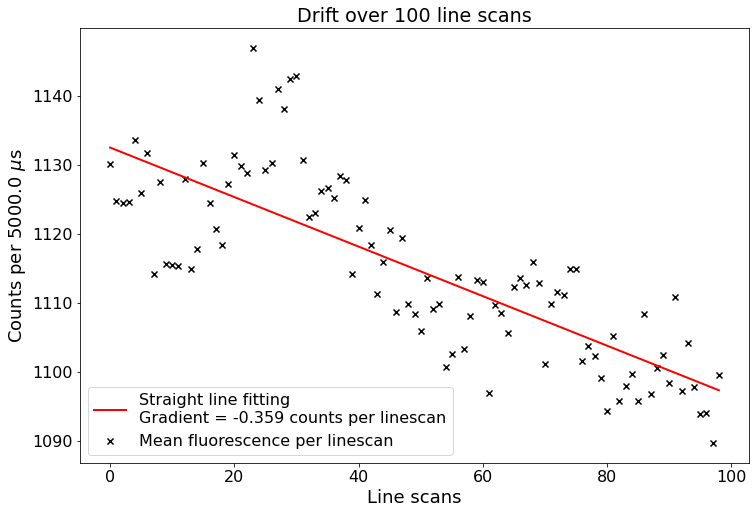

In [150]:
plot.scatter(x, mean_line_signal, marker = 'x', 
             color = 'k', label = 'Mean fluorescence per linescan')
plot.plot(x, y_fit, color = 'r', 
         linewidth = '2', label = 'Straight line fitting \nGradient = ' + str(round(y_opt_fit[0],3)) + ' counts per linescan')

plot.xlabel('Line scans', fontsize = 18)
plot.ylabel('Counts per ' + str(params_values[3]) + r' $\mu$s', fontsize = 18)
plot.title('Drift over ' + str(lines_to_group) + ' line scans')
plot.legend(loc = 'lower left')

### Code note 

This is the exact analysis as for the above, but converting the line scan time base into time. 

In [128]:
# As above but for time rather than line scans. 
time = np.arange(lines_to_group)*len(freq)*params_values[3]*0.000001 # Get x in time. 
P0 = [1, mean_line_signal[0]]

y_opt_time_fit, time_conf = opt.curve_fit(straight_line, time, mean_line_signal, P0, 
                                       sigma = np.sqrt(mean_line_signal))
opt_time_error = np.sqrt(np.diag(time_conf))

y_time_fit = stright_line(time, y_opt_time_fit[0], y_opt_time_fit[1])

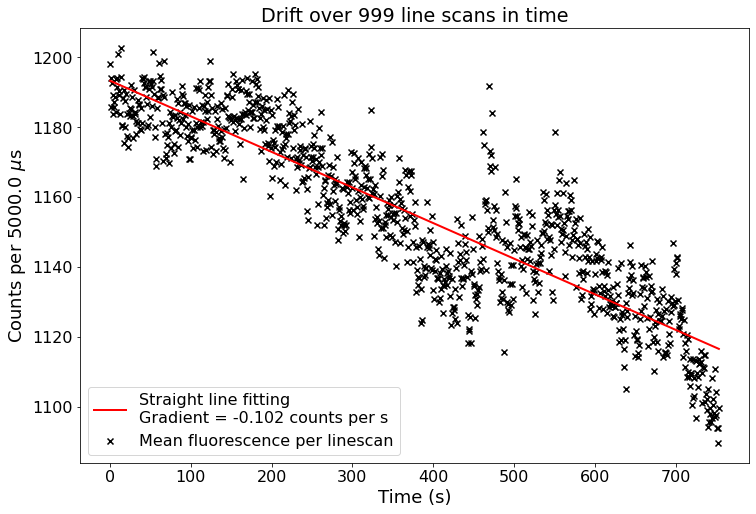

In [129]:
plot.scatter(time, mean_line_signal, marker = 'x', 
             color = 'k', label = 'Mean fluorescence per linescan')
plot.plot(time, y_time_fit, color = 'r', 
         linewidth = '2', label = 'Straight line fitting \nGradient = ' + str(round(y_opt_time_fit[0],3)) + ' counts per s')

plot.xlabel('Time (s)', fontsize = 18)
plot.ylabel('Counts per ' + str(params_values[3]) + r' $\mu$s', fontsize = 18)
plot.title('Drift over ' + str(lines_to_group) + ' line scans in time')
plot.legend(loc = 'lower left')